In [42]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
from scipy.stats import wasserstein_distance,median_abs_deviation
from scipy import stats
from tqdm.auto import tqdm
sys.path.append(os.path.abspath("../../src"))  # Adds 'src' to the module search path

In [43]:
from plot import plot_dataset_distributions,horizontal_boxplot,create_MAD_comparison_violinplot,plot_kde_grouped,plot_bar_vertical
from read_data import apply_index_file
tqdm.pandas()

In [44]:
np.random.seed(42)
DATASET = "../../raw_data/massive.parquet"

# Distribution analysis

In [45]:
df = pd.read_parquet(DATASET,engine="pyarrow")

In [46]:
df.head()

,modified_sequence,label,filename,dataset,task
0,MQIFVK,52.767529,131023_Sunil_PPT_Brain_A_02.mzML,MSV000080692,iRT
1,FLGFFK,107.360574,131023_Sunil_PPT_Brain_A_02.mzML,MSV000080692,iRT
2,REVILNKST,96.750319,131023_Sunil_PPT_Brain_A_02.mzML,MSV000080692,iRT
3,LQGIVSWGSGCAQK,150.020844,131023_Sunil_PPT_Brain_A_02.mzML,MSV000080692,iRT
4,FPFFLR,120.160845,131023_Sunil_PPT_Brain_A_02.mzML,MSV000080692,iRT


In [47]:
print(f"length of the dataset is {len(df)}")

length of the dataset is 45856811


In [48]:
df[['filename','dataset','modified_sequence']].nunique()

filename               2892
dataset                  62
modified_sequence    964395
dtype: int64

## Dataset distributions

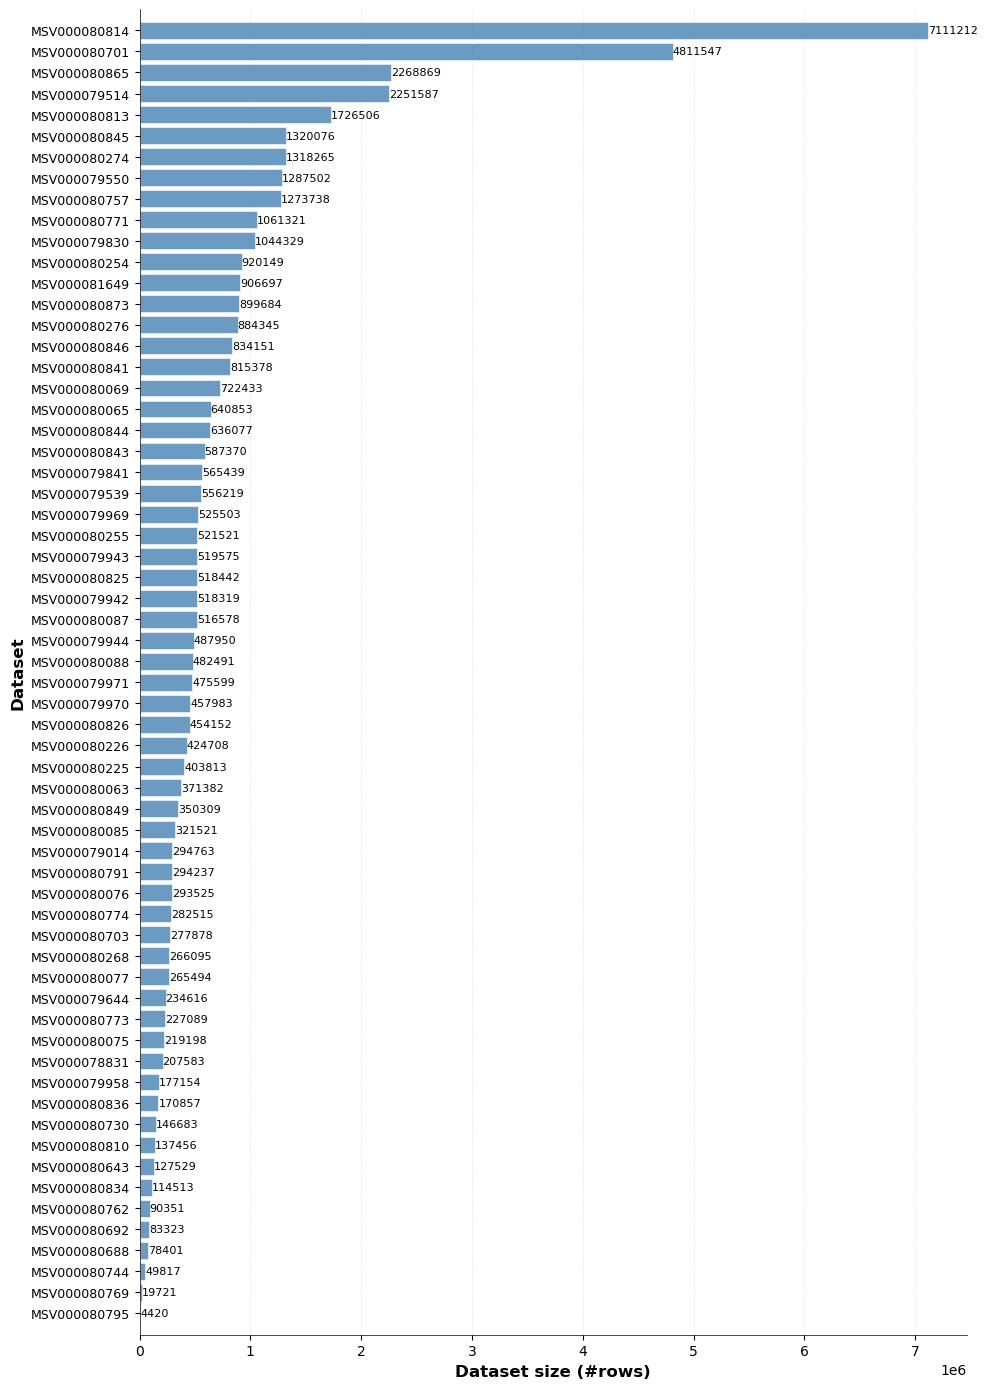

In [49]:
sequences_dataset = df.groupby('dataset')['modified_sequence'].count()
plot_dataset_distributions(sequences_dataset,'Dataset size (#rows)','Dataset')

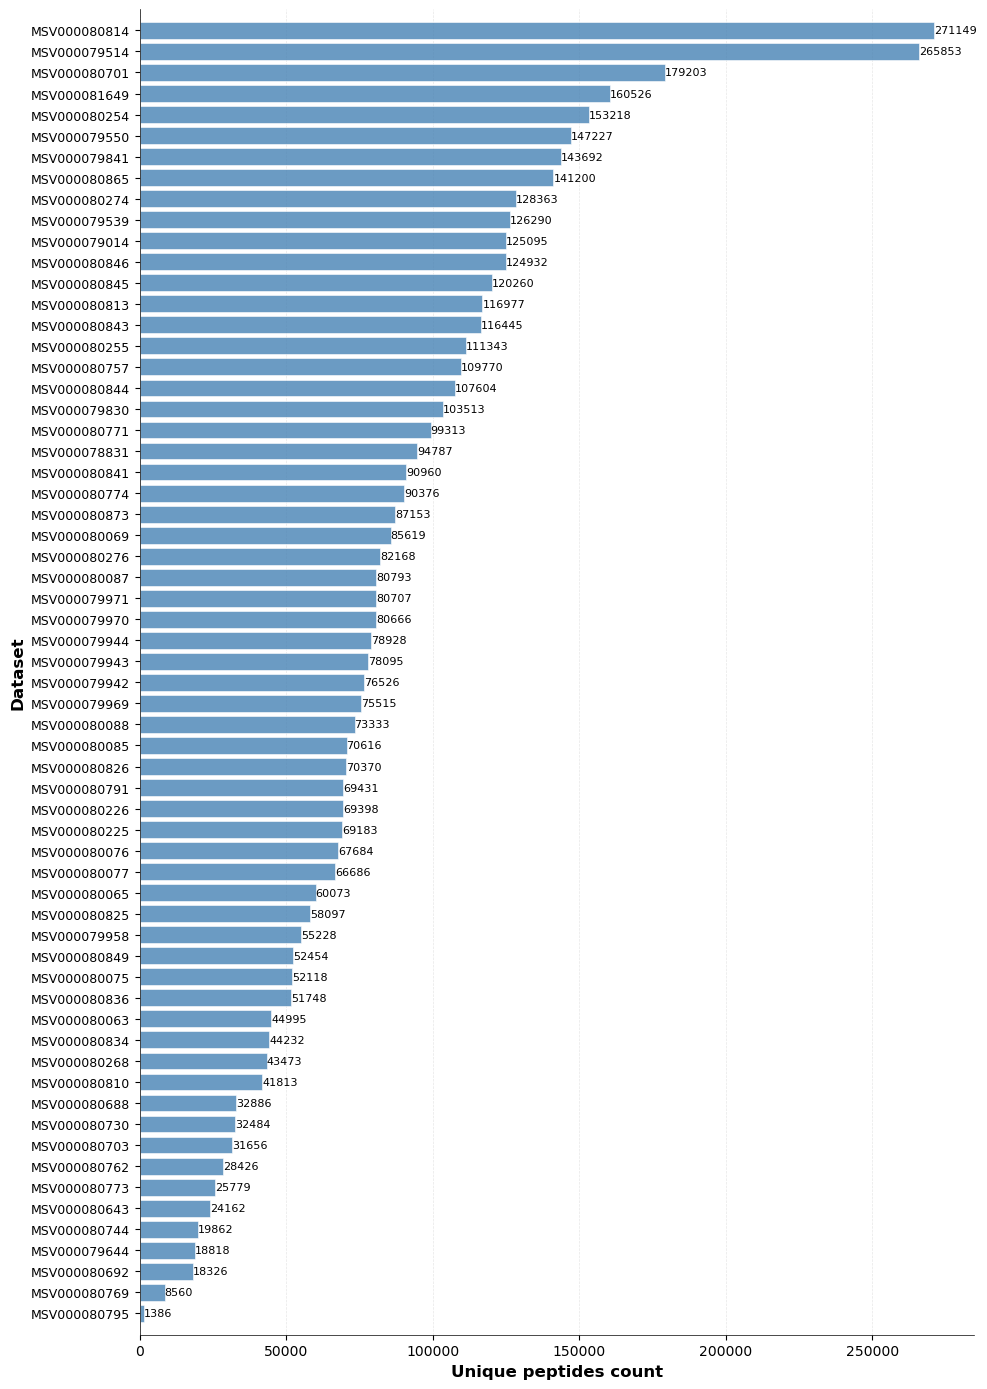

In [50]:
unique_sequences_dataset = df.groupby('dataset')['modified_sequence'].nunique()
plot_dataset_distributions(unique_sequences_dataset,'Unique peptides count','Dataset')

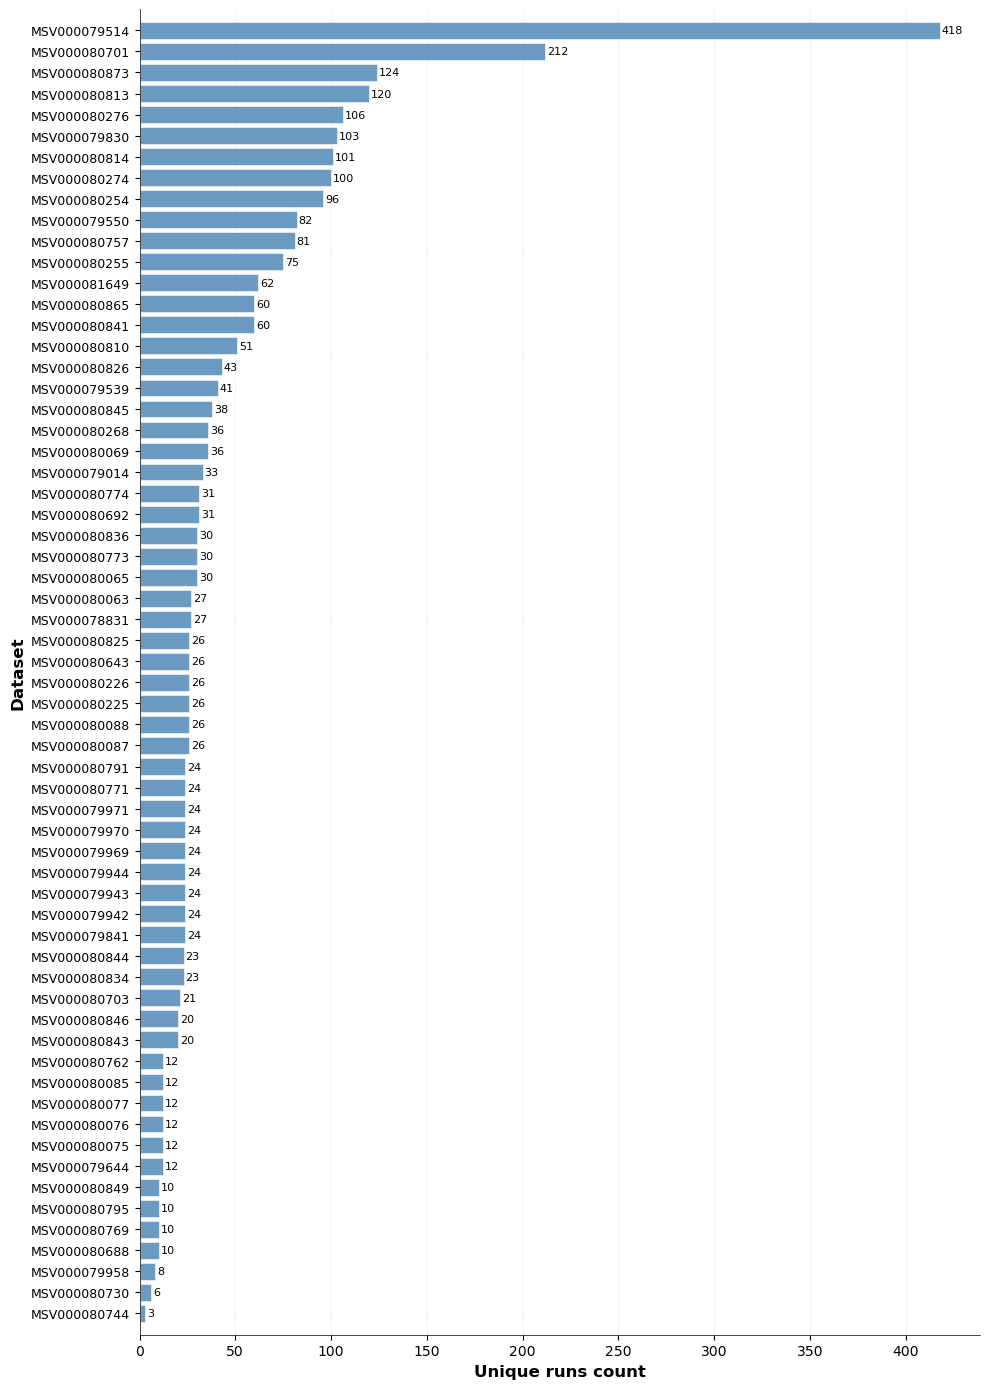

In [51]:
unique_filenames_dataset = df.groupby('dataset')['filename'].nunique()
plot_dataset_distributions(unique_filenames_dataset,'Unique runs count','Dataset')

## Peptide distributions

In [52]:
df = pd.read_parquet(DATASET,engine="pyarrow")

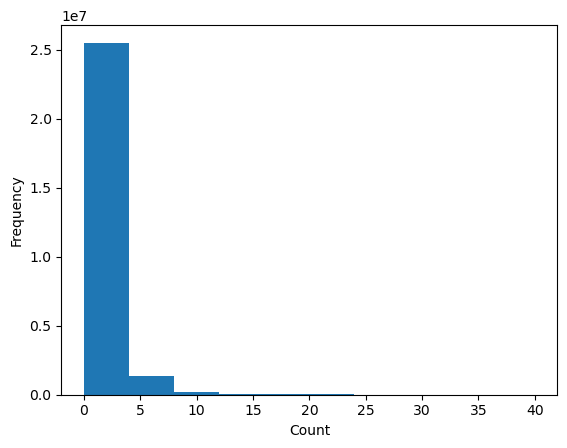

In [53]:
overlap_in_file = df.groupby(['modified_sequence','filename'])['filename'].count()
overlap_in_file.plot.hist(range=(0, 40))
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.show()

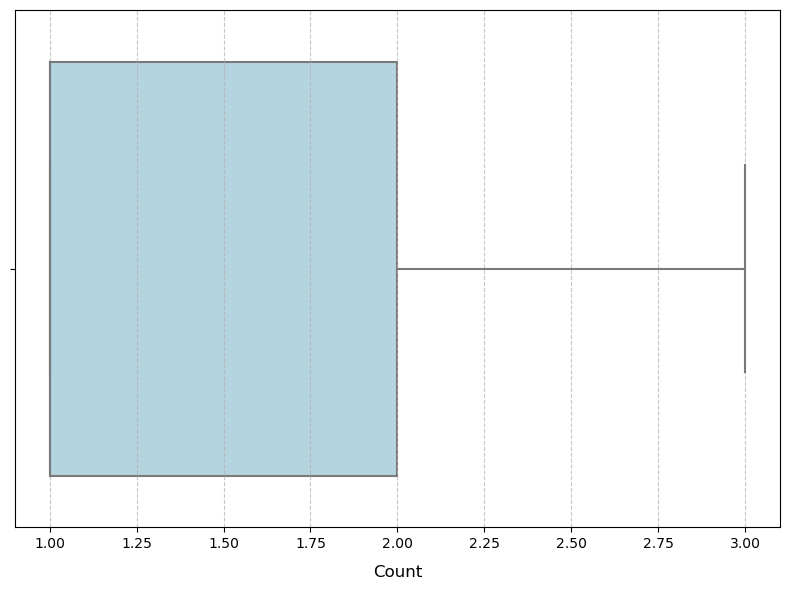

In [54]:
horizontal_boxplot(overlap_in_file,"Count")

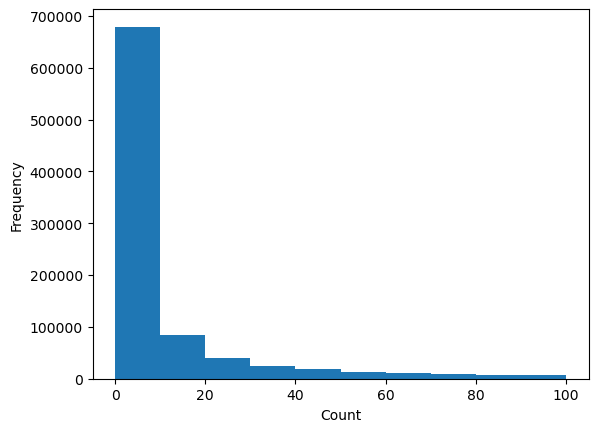

In [55]:
overlap_across_file = df.groupby('modified_sequence')['filename'].nunique()
overlap_across_file.plot.hist(range=(0, 100))
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.show()

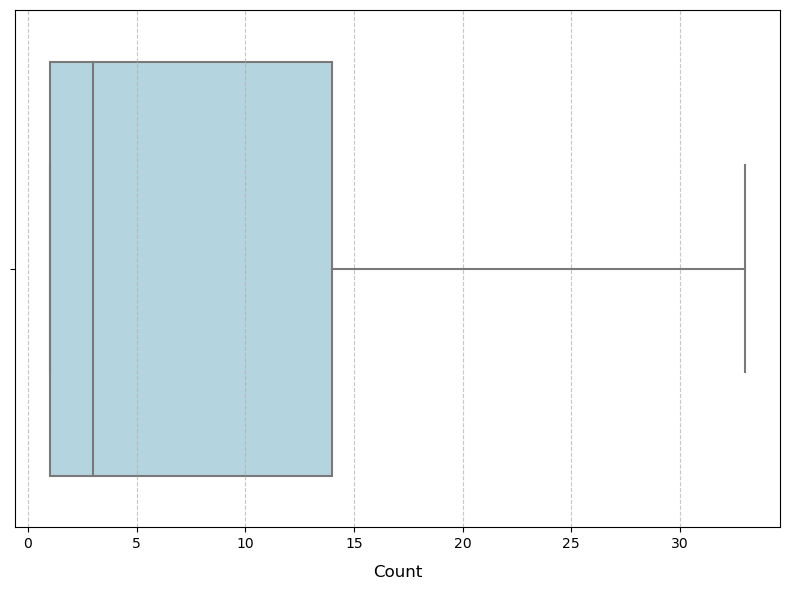

In [56]:
horizontal_boxplot(overlap_across_file,"Count")

# Retention time analysis

In [57]:
def median_absolute_deviation(series, threshold=None):
    if threshold is not None and len(series) < threshold:
        return None
    return stats.median_abs_deviation(series.values)

## MAD comparison

In [58]:
df = pd.read_parquet(DATASET,engine="pyarrow")

In [59]:
mad_msrun = df.groupby(['modified_sequence', 'filename'])['label'].progress_apply(
    lambda x: median_absolute_deviation(x, 2)
).dropna()

  0%|          | 0/27236456 [00:00<?, ?it/s]

In [60]:
mad_dataset = df.groupby(['modified_sequence', 'dataset'])['label'].progress_apply(
    lambda x: median_absolute_deviation(x, 2)
).dropna()

  0%|          | 0/5237543 [00:00<?, ?it/s]

In [61]:
mad_all = df.groupby(['modified_sequence'])['label'].progress_apply(
    lambda x: median_absolute_deviation(x, 2)
).dropna()

  0%|          | 0/964395 [00:00<?, ?it/s]

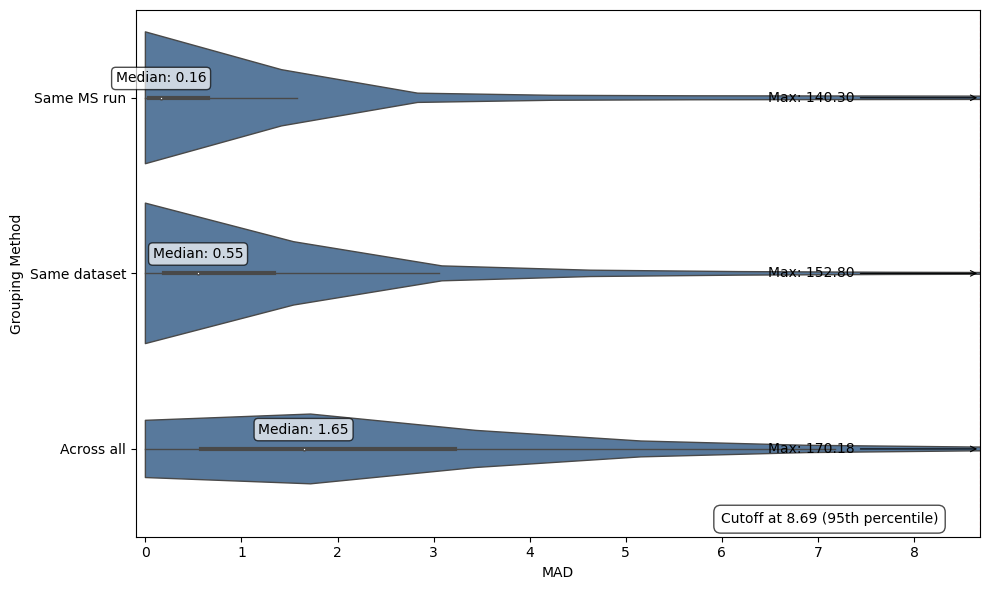

In [62]:
create_MAD_comparison_violinplot([mad_msrun,mad_dataset,mad_all],["Same MS run","Same dataset","Across all"],title="")

In [1]:
comparison = pd.Series(
    [mad_msrun.median(),mad_dataset.median(),mad_all.median()],
    index=["Same msrun","Same dataset","Across all"]
)
# Call the plotting function with the Series
plot_bar_vertical(
    data_series=comparison,
    title="",
    xlabel="",
    ylabel="Mean MAD",
    figsize=(10, 6)
)

NameError: name 'pd' is not defined

## MAD outliers

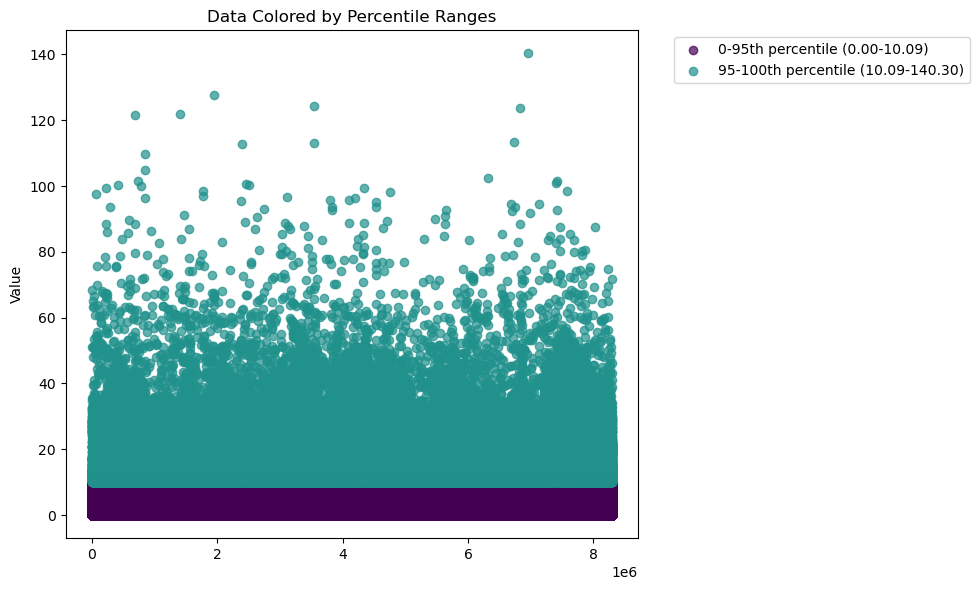

In [67]:
percentiles = [0, 95, 100]
perc_values = np.percentile(mad_msrun, percentiles)
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(percentiles)))

# Create index array
indices = np.arange(len(mad_msrun))

for i in range(len(percentiles)-1):
    mask = (mad_msrun >= perc_values[i]) & (mad_msrun <= perc_values[i+1])
    plt.scatter(indices[mask], mad_msrun[mask], 
               c=[colors[i]], alpha=0.7, 
               label=f'{percentiles[i]}-{percentiles[i+1]}th percentile ({perc_values[i]:.2f}-{perc_values[i+1]:.2f})')

plt.ylabel('Value')
plt.title('Data Colored by Percentile Ranges')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## KDE plots

In [68]:
df = pd.read_parquet(DATASET,engine="pyarrow")

In [69]:
overlap_all = df.groupby('modified_sequence')['filename'].nunique()
overlap_msrun = df.groupby(['modified_sequence','filename'])['filename'].count()

In [71]:
interesting_peptides_across = overlap_all[(overlap_all > 10) & (overlap_all < 30)].index
# Filter rows where the value is > 5
filtered = overlap_msrun[overlap_msrun > 5]

sequence_counts = filtered.groupby('modified_sequence').count()
interesting_peptides_inside = sequence_counts[sequence_counts > 5].index
interesting_peptides = interesting_peptides_across.intersection(interesting_peptides_inside)[:10]

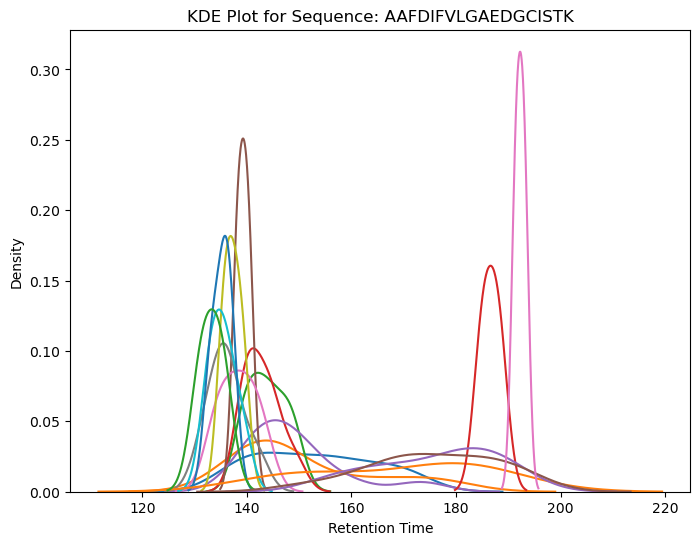

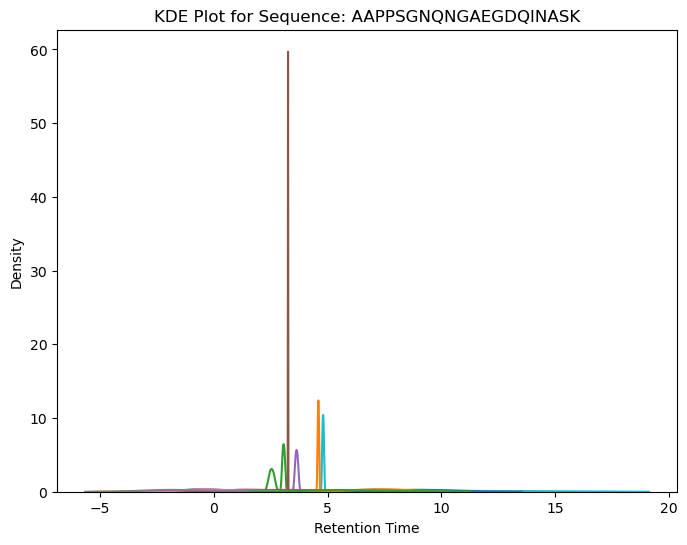

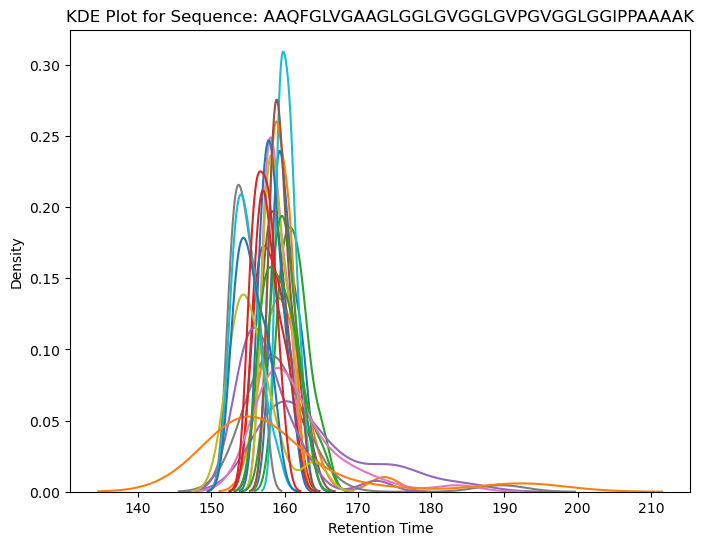

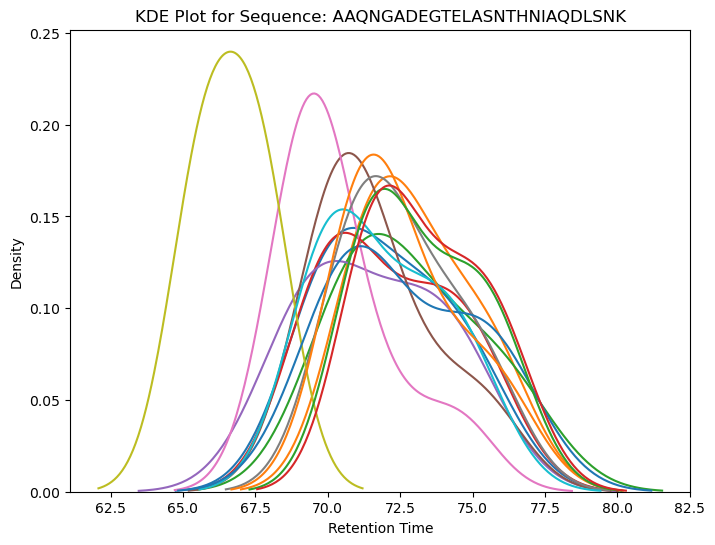

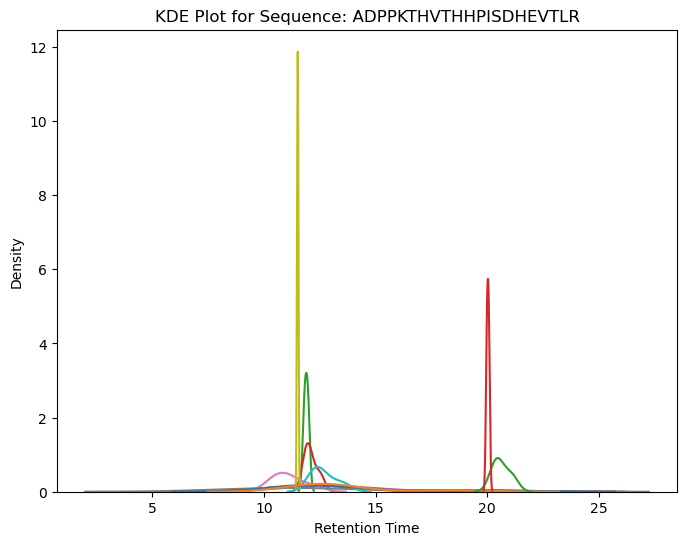

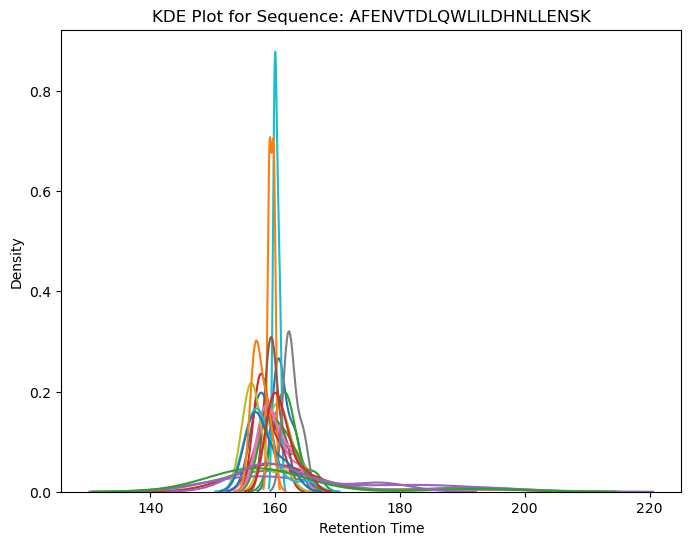

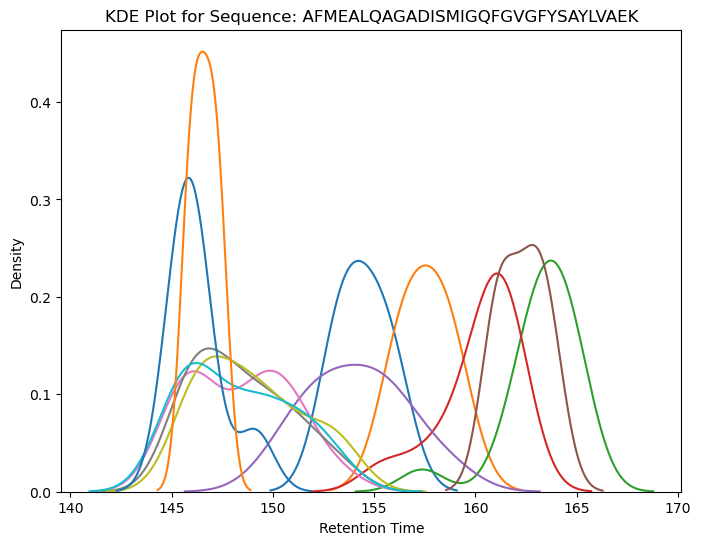

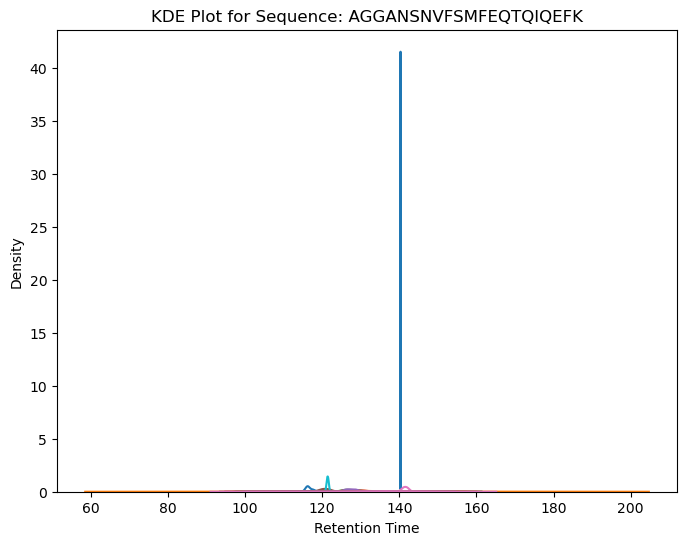

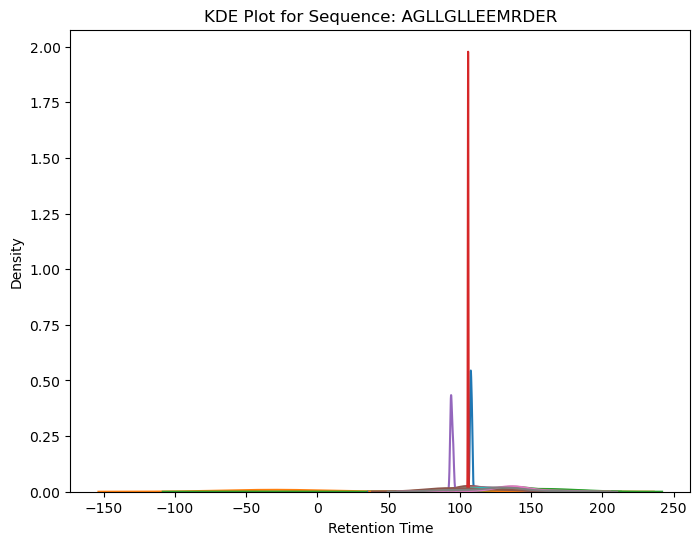

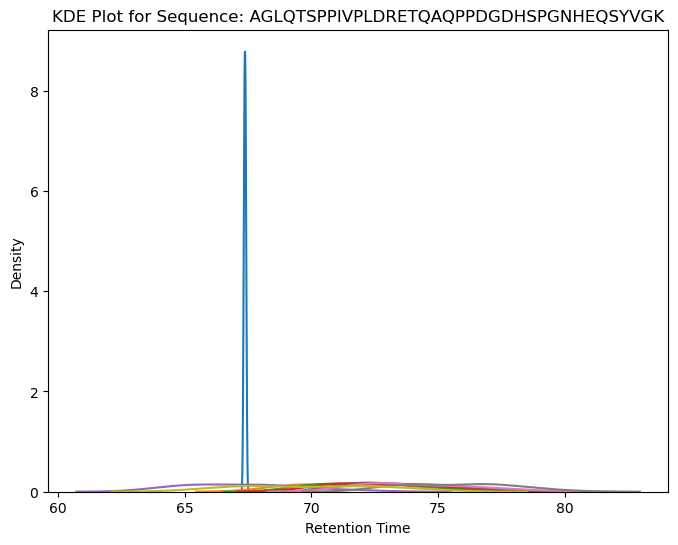

In [72]:
df_sequence = df[df['modified_sequence'].isin(interesting_peptides)]
plot_kde_grouped(df_sequence,2,legend=False)